In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2023-01-30,101.089996,101.739998,99.010002,100.550003,100.550003,70691900,AMAZON
2023-01-31,101.160004,103.349998,101.139999,103.129997,103.129997,66527300,AMAZON
2023-02-01,102.529999,106.239998,101.239998,105.150002,105.150002,80450100,AMAZON
2023-02-02,110.250000,114.000000,108.879997,112.910004,112.910004,158154200,AMAZON
2023-02-03,105.260002,108.779999,102.519997,103.389999,103.389999,144173400,AMAZON
2023-02-06,102.930000,103.949997,100.650002,102.180000,102.180000,81945200,AMAZON
2023-02-07,101.169998,102.410004,98.080002,102.110001,102.110001,119501300,AMAZON
2023-02-08,102.040001,102.669998,98.779999,100.050003,100.050003,75878300,AMAZON
2023-02-09,101.320000,101.779999,97.570000,98.239998,98.239998,64622500,AMAZON


In [4]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,151.172680,153.314040,149.166840,151.334440,150.759376,8.530116e+07
std,12.565075,12.464843,12.569125,12.566468,12.372435,2.324056e+07
min,126.010002,127.769997,124.169998,125.019997,124.829399,3.519590e+07
25%,142.099998,143.722496,139.924995,142.457497,141.965420,6.961018e+07
50%,149.455002,151.474998,147.770004,150.304993,149.881142,8.038435e+07
75%,161.092495,163.620003,159.204994,161.477497,160.805195,9.381580e+07
max,178.550003,179.610001,176.699997,178.960007,177.882446,1.826020e+08


In [5]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2022-02-14 to 2023-02-10
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          250 non-null    float64
 1   High          250 non-null    float64
 2   Low           250 non-null    float64
 3   Close         250 non-null    float64
 4   Adj Close     250 non-null    float64
 5   Volume        250 non-null    int64  
 6   company_name  250 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.6+ KB


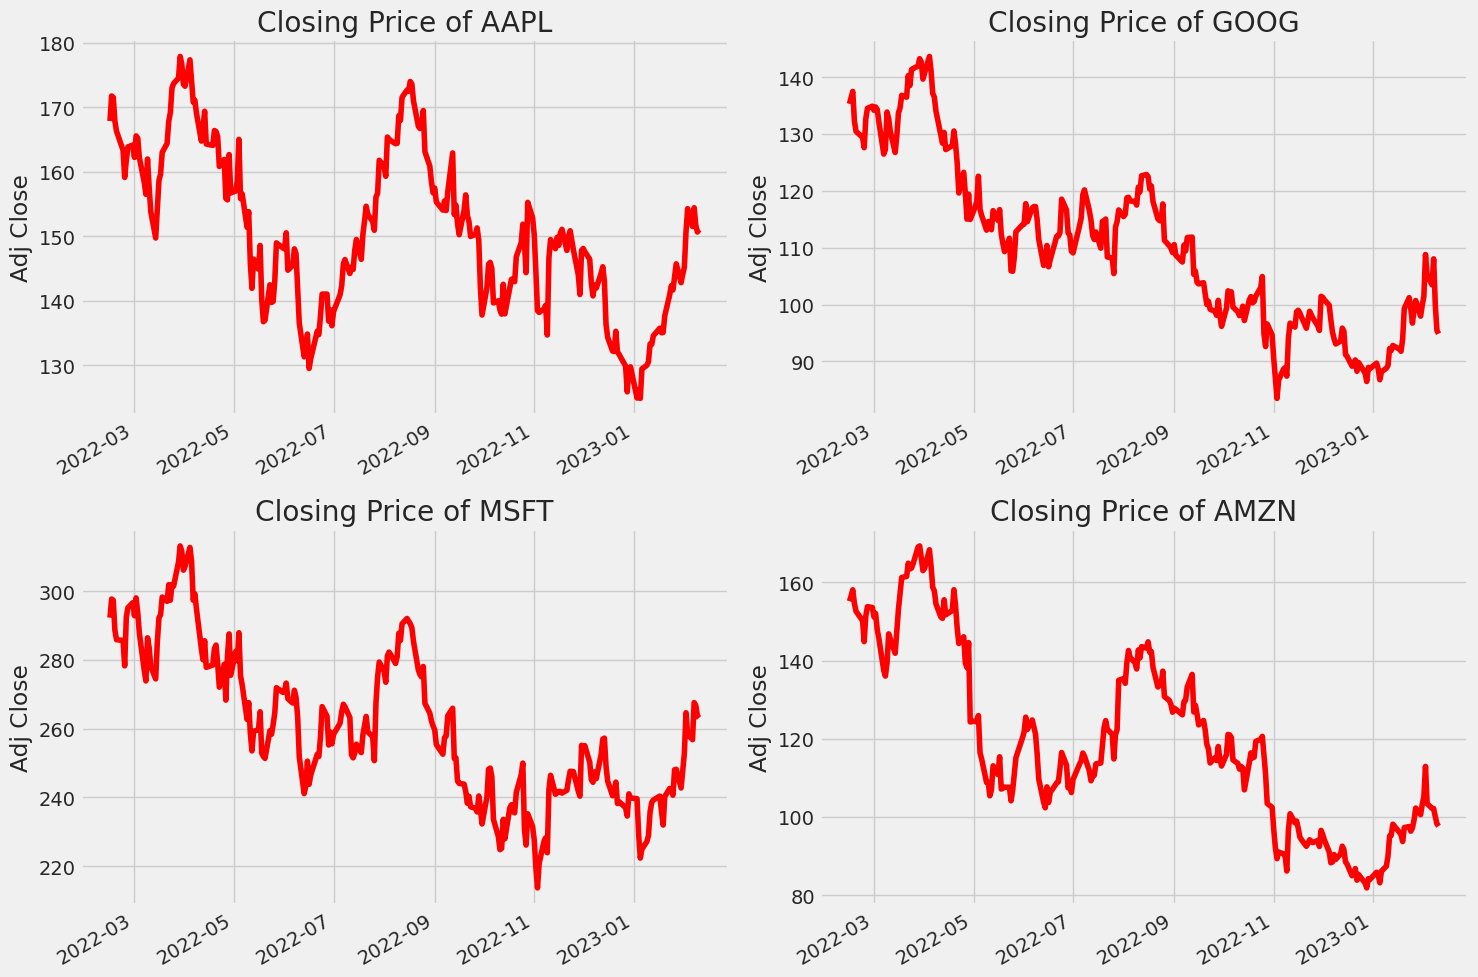

In [12]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot(color='r')
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

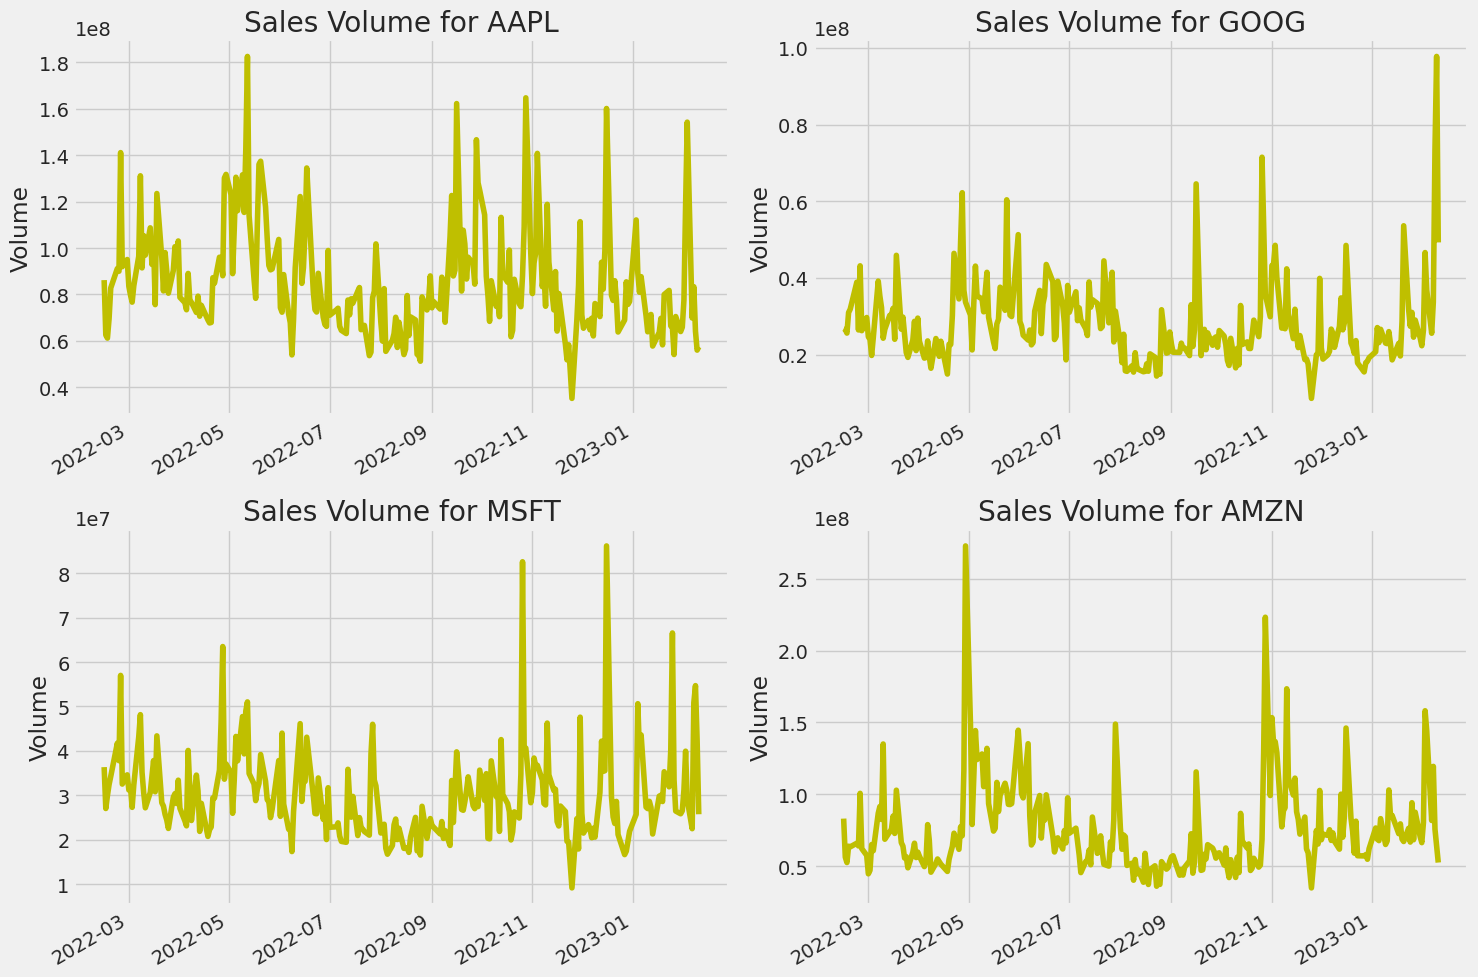

In [11]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i,)
    company['Volume'].plot(color='y')
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

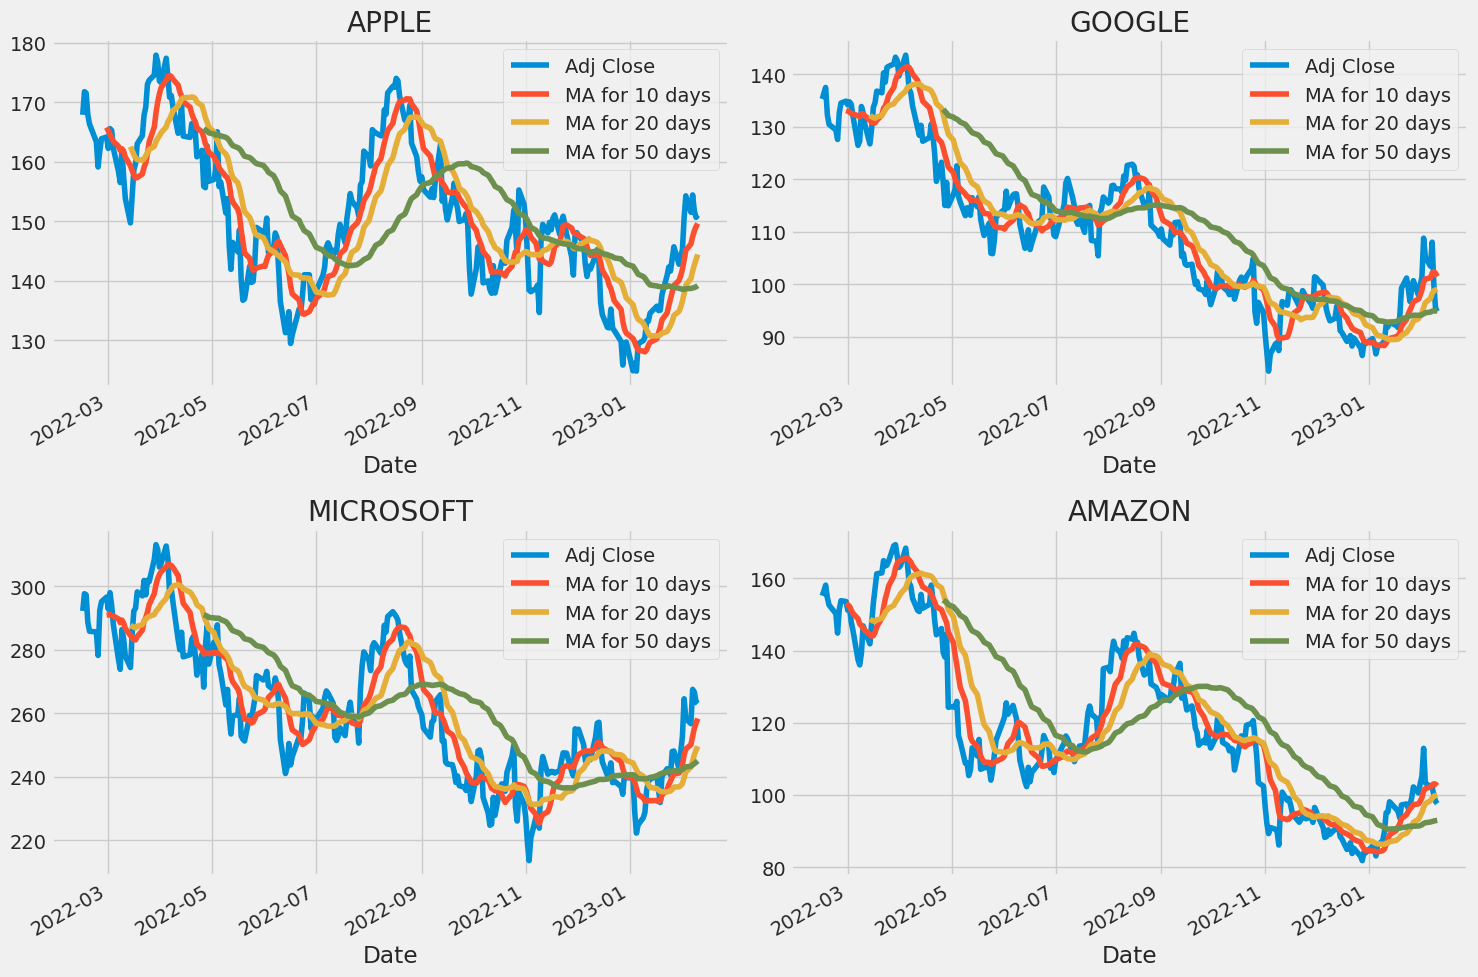

In [13]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

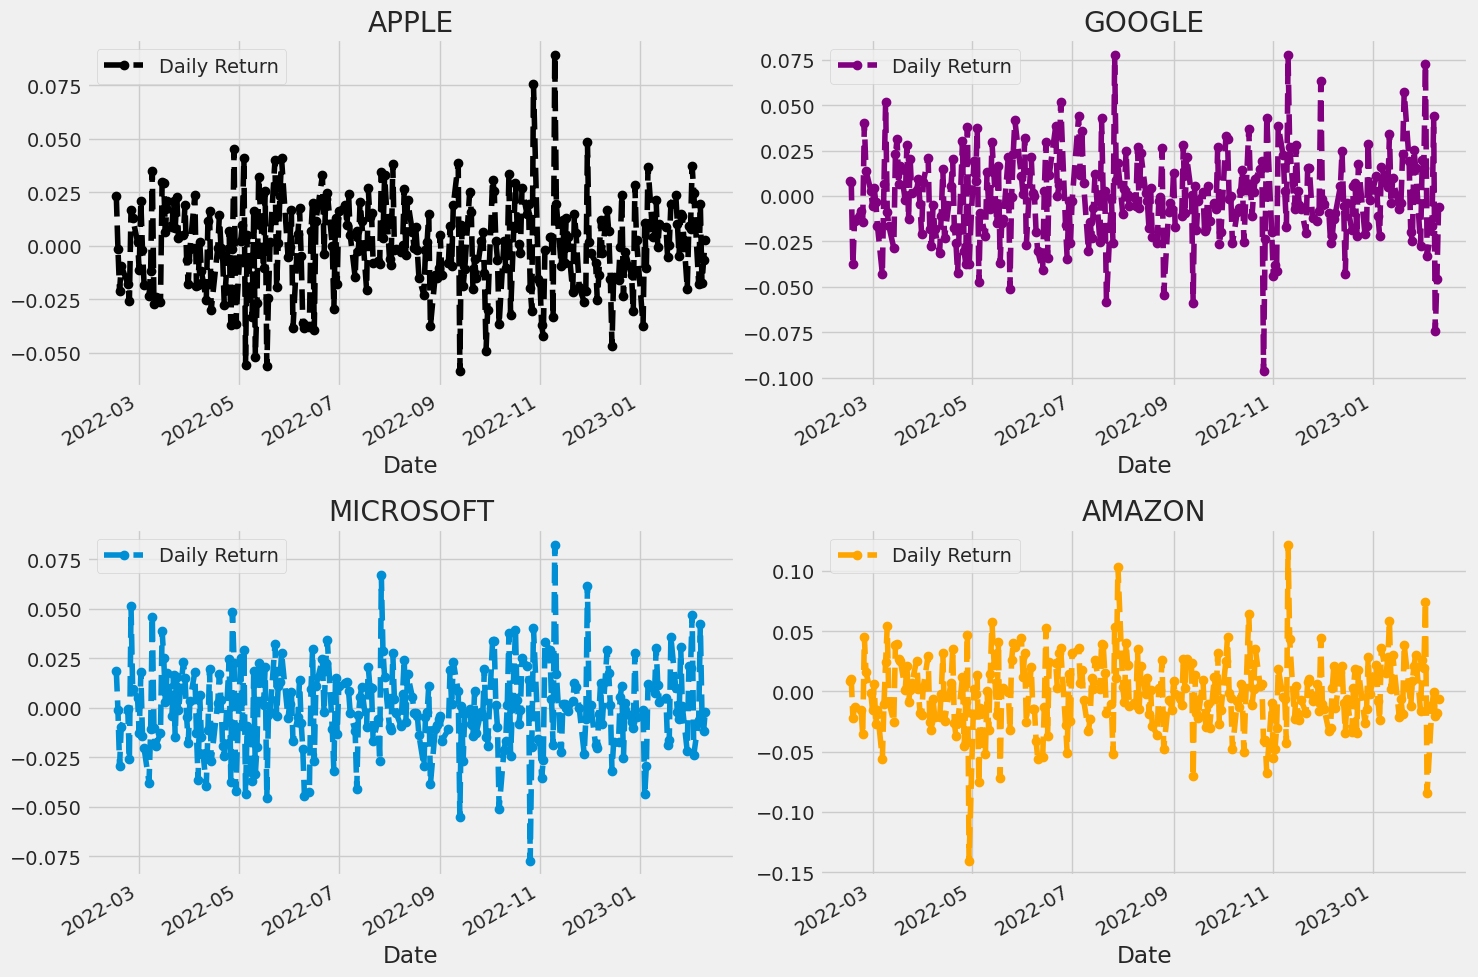

In [21]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o',color='black')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o',color='purple')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o',color='orange')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

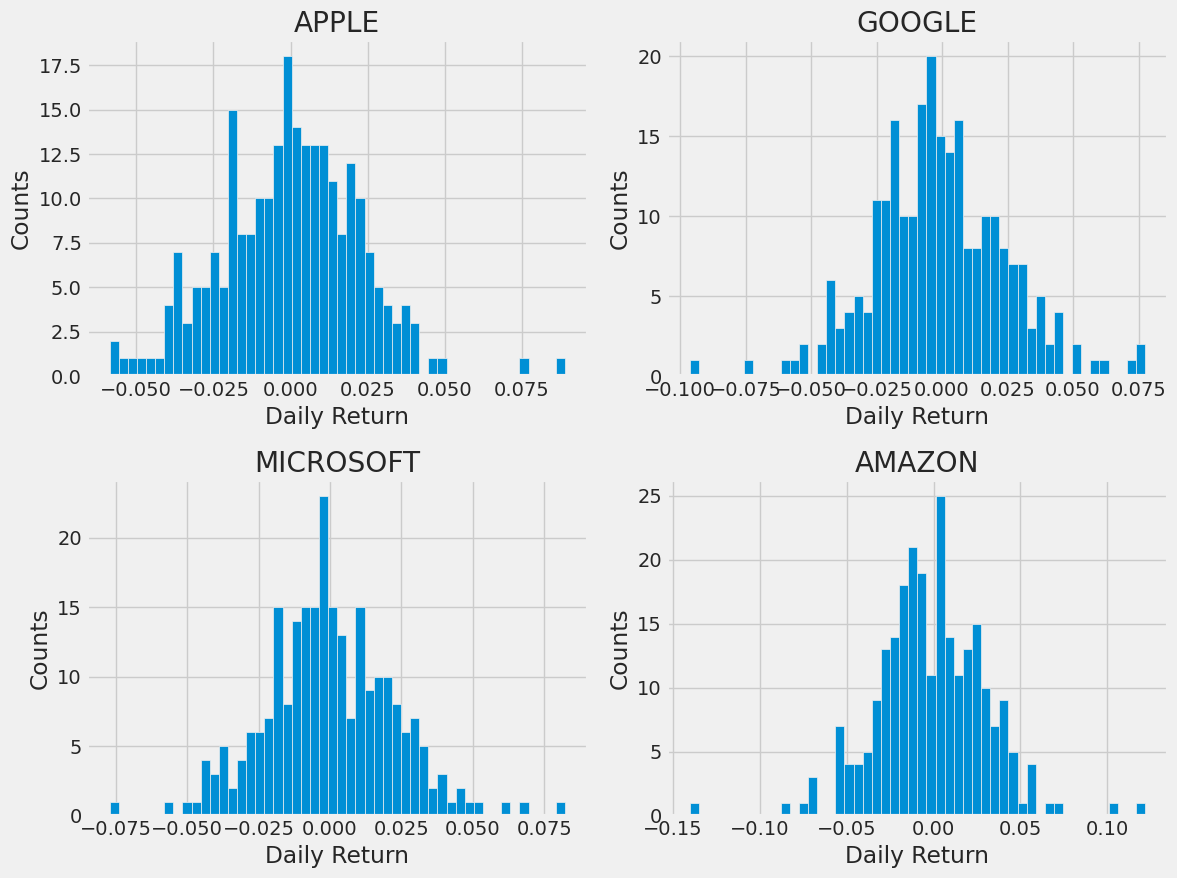

In [22]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

In [23]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%***********************]  4 of 4 completed


,AAPL,AMZN,GOOG,MSFT
Date,,,,
2022-02-14,NaN,NaN,NaN,NaN
2022-02-15,0.023152,0.008658,0.008319,0.018542
2022-02-16,-0.001389,0.010159,0.007784,-0.001167
2022-02-17,-0.021269,-0.021809,-0.037669,-0.029282
2022-02-18,-0.009356,-0.013262,-0.013914,-0.009631


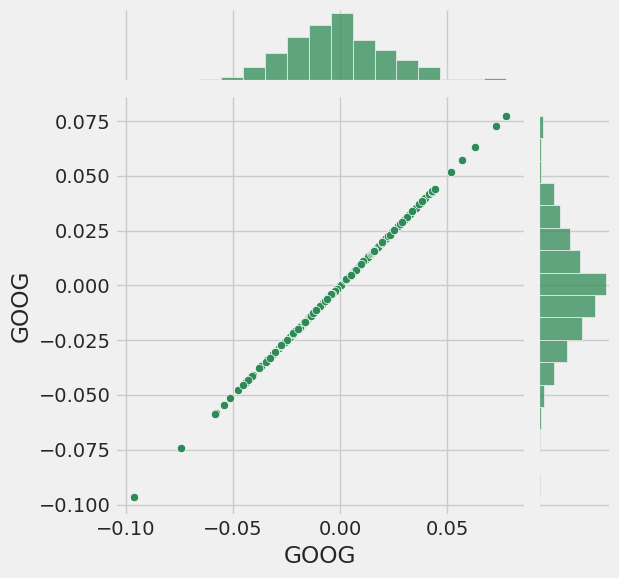

In [24]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')


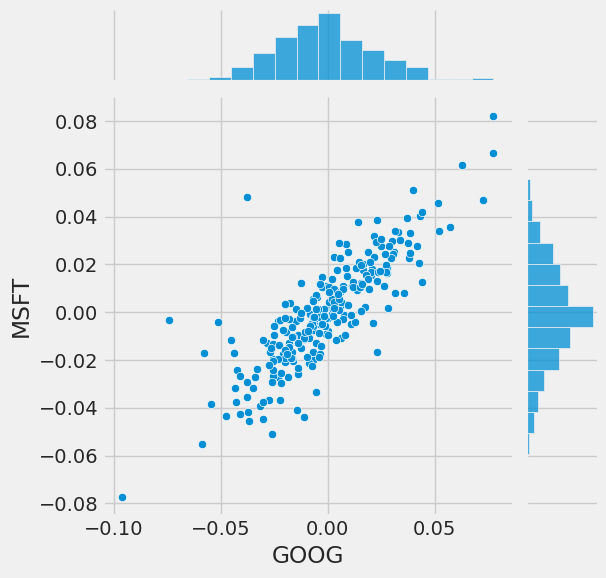

In [25]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')


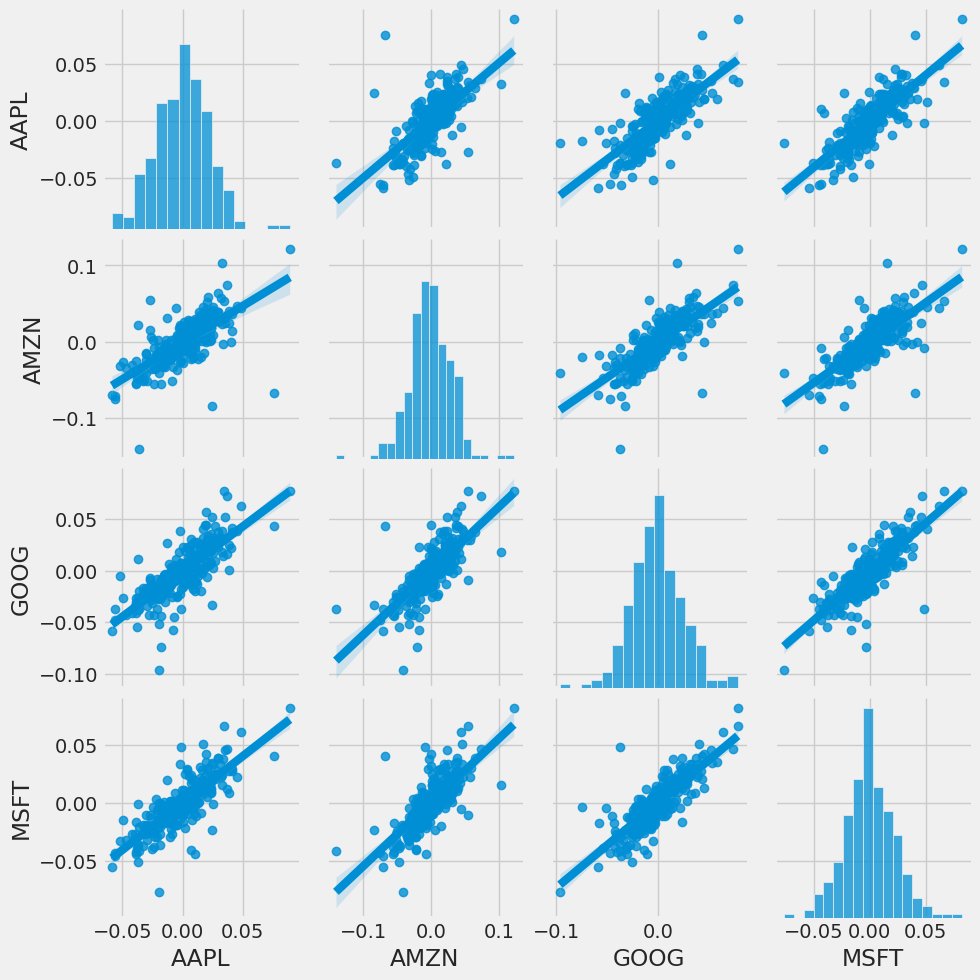

In [28]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

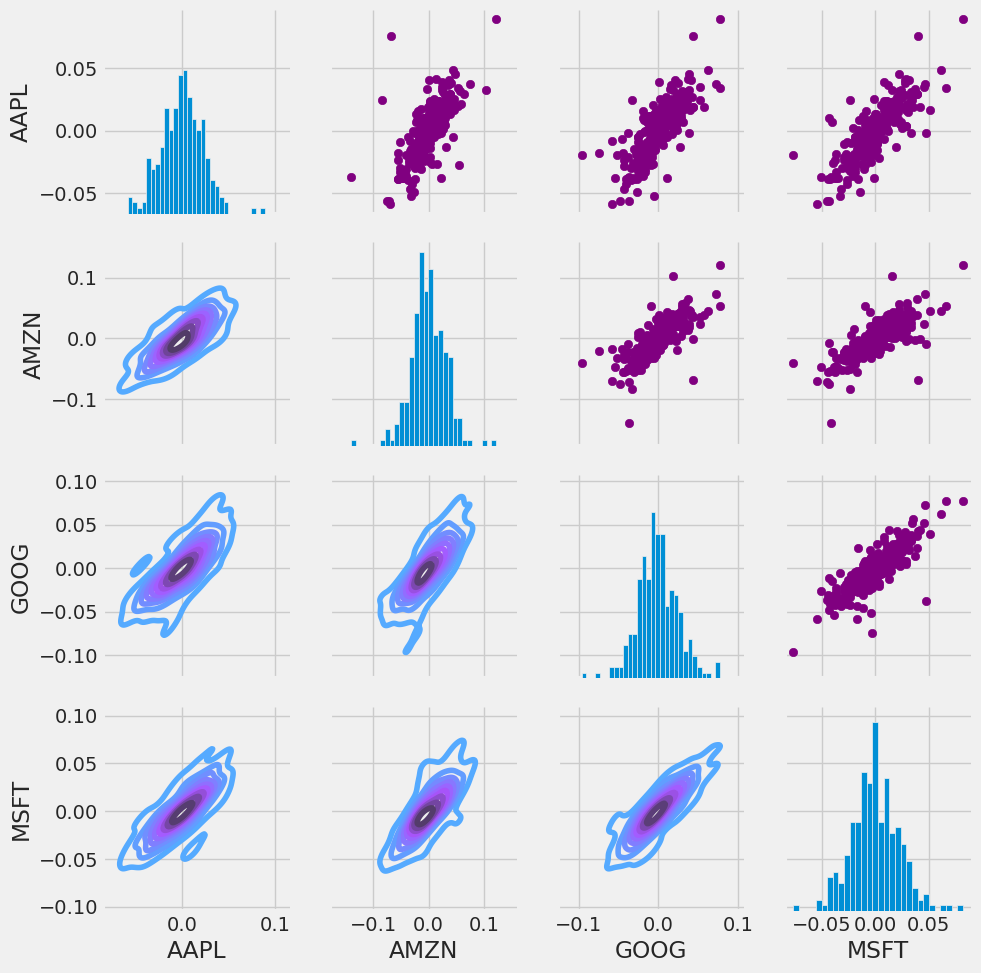

In [29]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

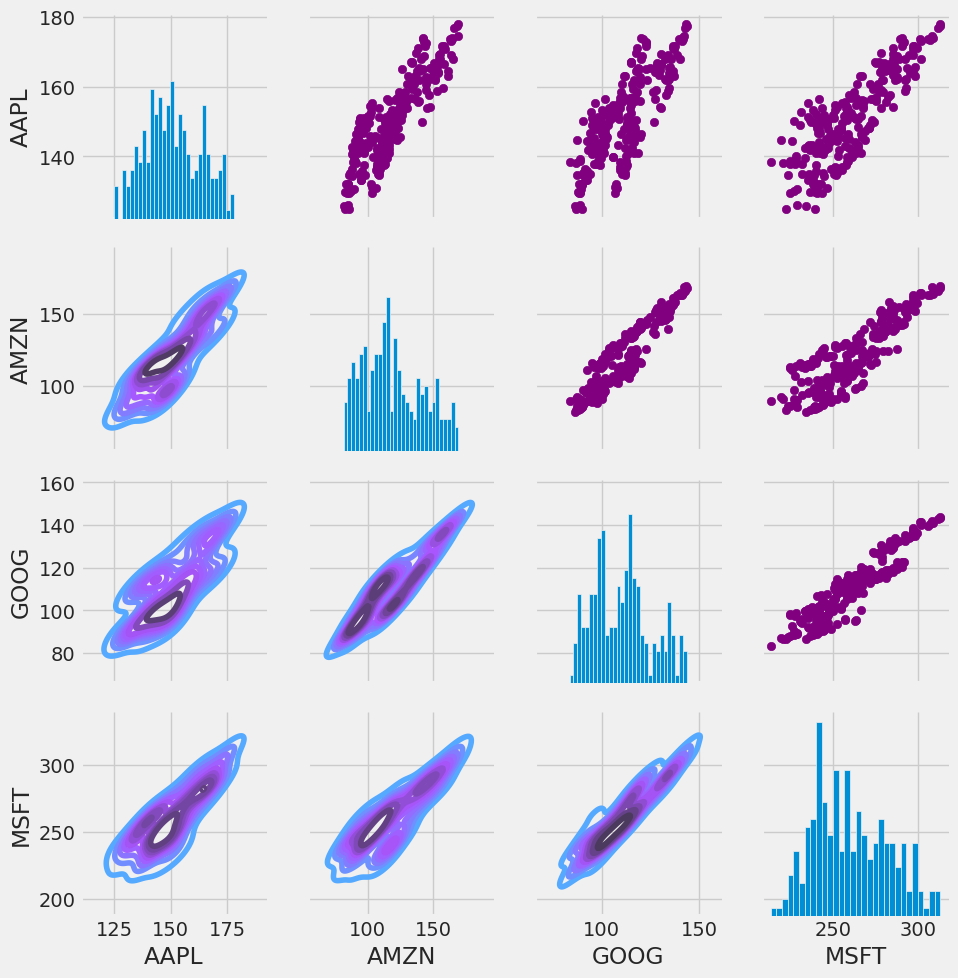

In [30]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

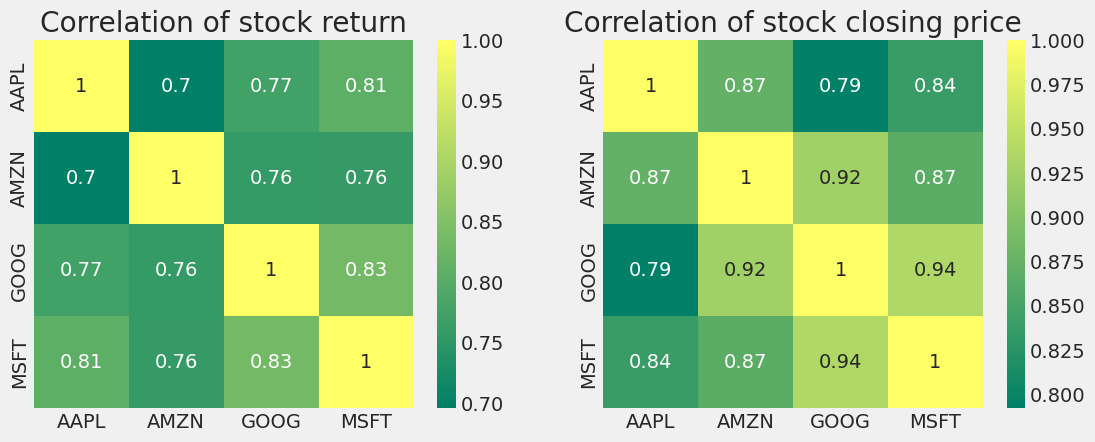

In [31]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

In [32]:
# How much value do we put at risk by investing in a particular stock?
# There are many ways we can quantify risk, one of the most basic ways using the information we've gathered on daily percentage returns is by comparing the expected return with the standard deviation of the daily returns.

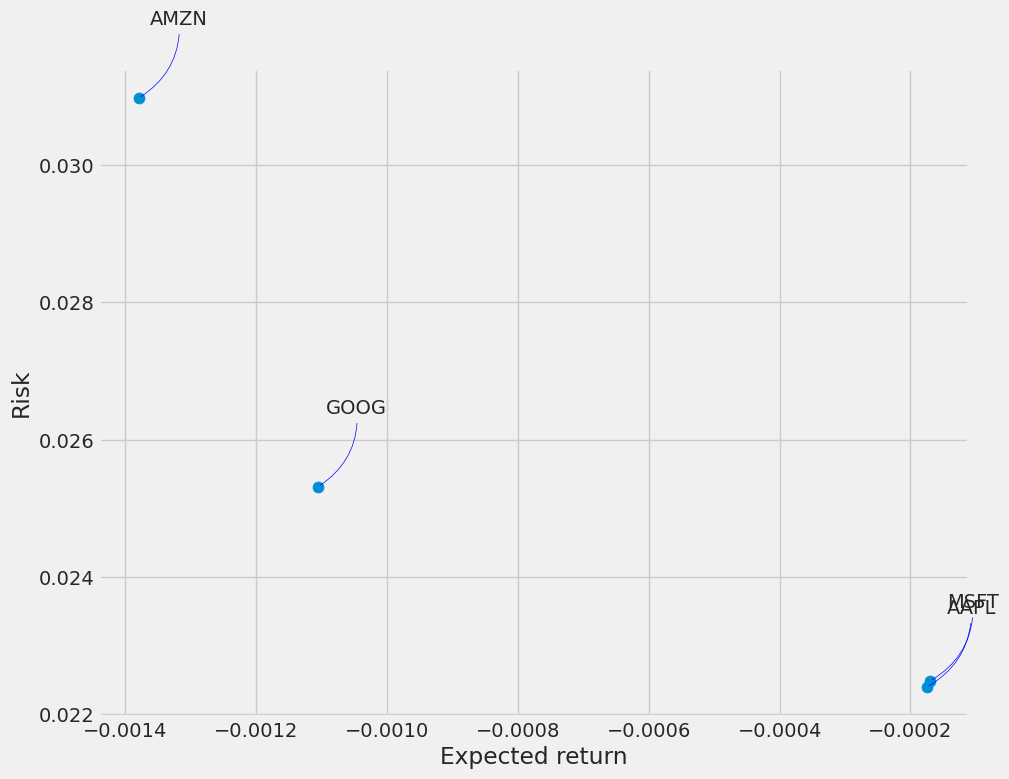

In [33]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [35]:
# Predicting the closing price stock price of APPLE inc:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500195,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567370,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706892,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839729,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819362,394024400
...,...,...,...,...,...,...
2023-02-06,152.570007,153.100006,150.779999,151.729996,151.498688,69858300
2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100


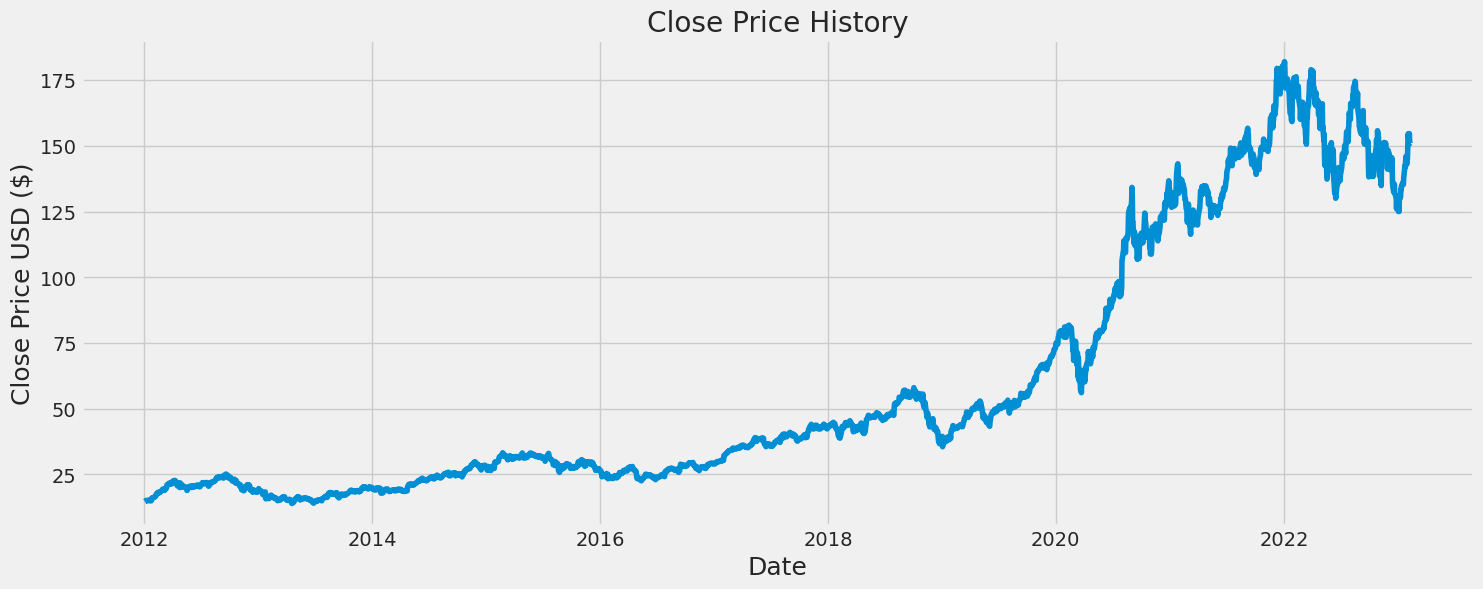

In [36]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [37]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2657

In [38]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.82095948],
       [0.81471179],
       [0.81554481]])

In [39]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00439887, 0.00486851, 0.00584391, 0.00677256, 0.00663019,
       0.00695107, 0.00680444, 0.00655793, 0.00622217, 0.00726133,
       0.00819848, 0.00790947, 0.0063263 , 0.00783722, 0.00634968,
       0.01192796, 0.01149658, 0.01205972, 0.01327737, 0.01401476,
       0.01395314, 0.01372576, 0.01469479, 0.01560643, 0.01663922,
       0.01830739, 0.02181161, 0.02186474, 0.02381555, 0.02527333,
       0.0227679 , 0.02373267, 0.02371354, 0.02641875, 0.02603411,
       0.026746  , 0.02802528, 0.02873719, 0.03078787, 0.03228178,
       0.03271317, 0.03286405, 0.03030973, 0.02969346, 0.02978484,
       0.03218616, 0.03286193, 0.03431335, 0.03773469, 0.04229932,
       0.04144504, 0.04144716, 0.04474738, 0.04578017, 0.04504489,
       0.04437338, 0.04367423, 0.04599691, 0.04759072, 0.04825798])]
[0.04660893460974819]

[array([0.00439887, 0.00486851, 0.00584391, 0.00677256, 0.00663019,
       0.00695107, 0.00680444, 0.00655793, 0.00622217, 0.00726133,
       0.00819848, 0.00790947, 0.00

In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-02-12 03:06:51.871343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 03:06:52.494197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-12 03:06:52.494244: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-12 03:06:54.353477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

2597/2597 [==============================] - 101s 37ms/step - loss: 0.0012


In [41]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse


5/5 [==============================] - 1s 35ms/step


6.261704842604692

/tmp/ipykernel_15176/2388977846.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


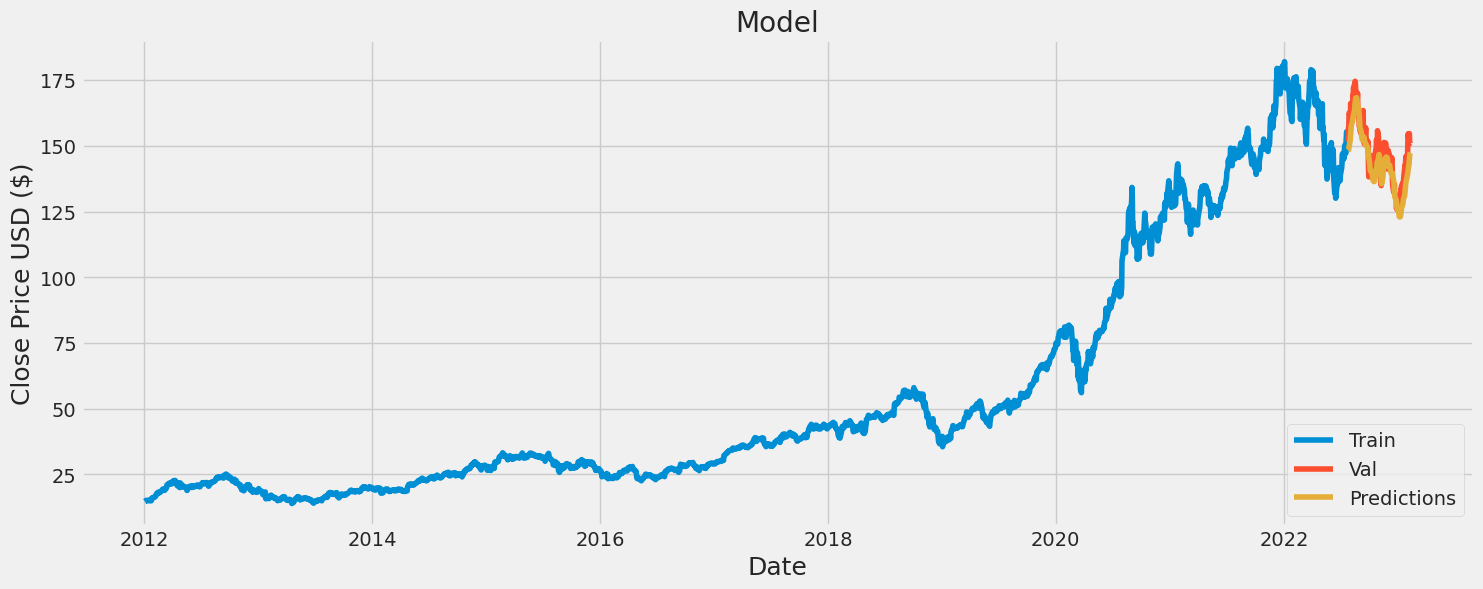

In [42]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [45]:
# Show the valid and predicted prices
valid


,Close,Predictions
Date,,
2022-07-26,151.600006,148.272690
2022-07-27,156.789993,148.377106
2022-07-28,157.350006,149.092743
2022-07-29,162.509995,150.029816
2022-08-01,161.509995,151.786774
...,...,...
2023-02-06,151.729996,142.956879
2023-02-07,154.649994,144.573364
2023-02-08,151.919998,146.212143


# Tesla Stocks

In [60]:
maindf = pd.read_csv('teslastocks.csv')
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
maindf.head()

,date,open,high,low,close,volume
0,02/10/2023,202.23,206.20,192.89,196.89,"204,754,094"
1,02/09/2023,207.78,214.00,204.77,207.32,"215,431,391"
2,02/08/2023,196.10,203.00,194.31,201.29,"180,673,594"
3,02/07/2023,196.43,197.50,189.55,196.81,"186,010,297"
4,02/06/2023,193.01,198.17,189.92,194.76,"186,188,094"


In [61]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  112
Total number of fields:  6


In [68]:
#Checking the number of Null and NA values
print('Null values is ',maindf.isnull().values.sum())
print('NA values is ',maindf.isna().values.any())

Null values is  0
NA values is  False


In [63]:
# convert date field from string to Date format 
maindf['date']=pd.to_datetime(maindf.date)
maindf.head()

,date,open,high,low,close,volume
0,2023-02-10,202.23,206.20,192.89,196.89,"204,754,094"
1,2023-02-09,207.78,214.00,204.77,207.32,"215,431,391"
2,2023-02-08,196.10,203.00,194.31,201.29,"180,673,594"
3,2023-02-07,196.43,197.50,189.55,196.81,"186,010,297"
4,2023-02-06,193.01,198.17,189.92,194.76,"186,188,094"


In [64]:
# EDA
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2023-02-10 00:00:00
Ending date:  2022-09-01 00:00:00
Duration:  -162 days +00:00:00


In [65]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,132.316000,134.196000
February,192.590000,194.591250
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,287.885714,288.734762


In [66]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [69]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

In [70]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'], 
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [71]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)


Shape of close dataframe: (112, 2)


In [72]:
# Plotting close price stock :
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [75]:
closedf = closedf[closedf['date'] > '2022-10-16']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])


Total data for prediction:  81


In [76]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [77]:
# Normalizing close price
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(81, 1)


In [78]:
training_size_tesla=int(len(closedf)*0.60)
test_size_tesla=len(closedf)-training_size_tesla
train_data_tesla,test_data_tesla=closedf[0:training_size_tesla,:],closedf[training_size_tesla:len(closedf),:1]
print("train_data_tesla: ", train_data_tesla.shape)
print("test_data_tesla: ", test_data_tesla.shape)

train_data_tesla:  (48, 1)
test_data_tesla:  (33, 1)


In [79]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [81]:
time_step = 15
X_train_tesla, y_train_tesla = create_dataset(train_data_tesla, time_step)
X_test_tesla, y_test_tesla = create_dataset(test_data_tesla, time_step)

print("X_train_tesla: ", X_train_tesla.shape)
print("y_train_tesla: ", y_train_tesla.shape)
print("X_test_tesla: ", X_test_tesla.shape)
print("y_test_tesla", y_test_tesla.shape)

X_train_tesla:  (32, 15)
y_train_tesla:  (32,)
X_test_tesla:  (17, 15)
y_test_tesla (17,)


In [82]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train_tesla =X_train_tesla.reshape(X_train_tesla.shape[0],X_train_tesla.shape[1] , 1)
X_test_tesla = X_test_tesla.reshape(X_test_tesla.shape[0],X_test_tesla.shape[1] , 1)

print("X_train_tesla: ", X_train_tesla.shape)
print("X_test_tesla: ", X_test_tesla.shape)

X_train_tesla:  (32, 15, 1)
X_test_tesla:  (17, 15, 1)


In [83]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [84]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(X_train_tesla,y_train_tesla,validation_data=(X_test_tesla,y_test_tesla),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 0.0944 - val_loss: 0.6549
Epoch 2/200
1/1 [==============================] - 0s 78ms/step - loss: 0.0781 - val_loss: 0.5523
Epoch 3/200
1/1 [==============================] - 0s 76ms/step - loss: 0.0603 - val_loss: 0.4588
Epoch 4/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0499 - val_loss: 0.3730
Epoch 5/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0426 - val_loss: 0.2946
Epoch 6/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0326 - val_loss: 0.2241
Epoch 7/200
1/1 [==============================] - 0s 72ms/step - loss: 0.0314 - val_loss: 0.1641
Epoch 8/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0252 - val_loss: 0.1176
Epoch 9/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0302 - val_loss: 0.0855
Epoch 10/200
1/1 [==============================] - 0s 80ms/step - loss: 0.0323 - val_loss: 0.0683
Epoch 11/200
1/1 [===

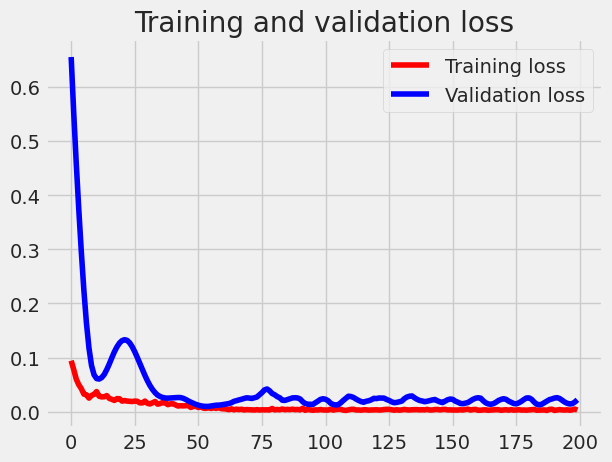

<Figure size 640x480 with 0 Axes>

In [86]:
# Plotting Loss chart:

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [87]:
### Lets Do the prediction and check performance metrics
train_predict_tesla=model.predict(X_train_tesla)
test_predict_tesla=model.predict(X_test_tesla)
train_predict_tesla.shape, test_predict_tesla.shape

1/1 [==============================] - 2s 2s/step


((32, 1), (17, 1))

In [88]:
# Transform back to original form

train_predict_tesla = scaler.inverse_transform(train_predict_tesla)
test_predict_tesla = scaler.inverse_transform(test_predict_tesla)
original_ytrain_tesla = scaler.inverse_transform(y_train_tesla.reshape(-1,1)) 
original_ytest_tesla = scaler.inverse_transform(y_test_tesla.reshape(-1,1))

In [89]:
# Evaluation metrices RMSE and MAE
print("Train data Tesla RMSE: ", math.sqrt(mean_squared_error(original_ytrain_tesla,train_predict_tesla)))
print("Train data Tesla MSE: ", mean_squared_error(original_ytrain_tesla,train_predict_tesla))
print("Train data Tesla MAE: ", mean_absolute_error(original_ytrain_tesla,train_predict_tesla))
print("-------------------------------------------------------------------------------------")
print("Test data Tesla RMSE: ", math.sqrt(mean_squared_error(original_ytest_tesla,test_predict_tesla)))
print("Test data Tesla MSE: ", mean_squared_error(original_ytest_tesla,test_predict_tesla))
print("Test data Tesla MAE: ", mean_absolute_error(original_ytest_tesla,test_predict_tesla))


Train data Tesla RMSE:  6.049803615649004
Train data Tesla MSE:  36.600123787919756
Train data Tesla MAE:  4.890438194274903
-------------------------------------------------------------------------------------
Test data Tesla RMSE:  17.928304169111435
Test data Tesla MSE:  321.4240903801784
Test data Tesla MAE:  15.924818222943472


In [90]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain_tesla, train_predict_tesla))
print("Test data explained variance regression score:", explained_variance_score(original_ytest_tesla, test_predict_tesla))

Train data explained variance regression score: 0.9332439479400064
Test data explained variance regression score: 0.4592976891162128


In [91]:
print("Train data R2 score:", r2_score(original_ytrain_tesla, train_predict_tesla))
print("Test data R2 score:", r2_score(original_ytest_tesla, test_predict_tesla))


Train data R2 score: 0.9320892683279893
Test data R2 score: -0.6968757059479123


In [92]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain_tesla, train_predict_tesla))
print("Test data MGD: ", mean_gamma_deviance(original_ytest_tesla, test_predict_tesla))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain_tesla, train_predict_tesla))
print("Test data MPD: ", mean_poisson_deviance(original_ytest_tesla, test_predict_tesla))


Train data MGD:  0.0022649183882811064
Test data MGD:  0.008021272975656343
----------------------------------------------------------------------
Train data MPD:  0.2857792576274738
Test data MPD:  1.6032031130626712


In [94]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_tesla)+look_back, :] = train_predict_tesla
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_tesla)+(look_back*2)+1:len(closedf)-1, :] = test_predict_tesla
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (81, 1)
Test predicted data:  (81, 1)


In [95]:
# Prediction next 30 days:
x_input=test_data_tesla[len(test_data_tesla)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [96]:
# Prediction last 15 days :
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [101]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [102]:
# Plotting entire Closing Stock Price with next 30 days period of prediction:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
